In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is available
Using GPU: NVIDIA GeForce GTX 1070


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
import matplotlib.pyplot as plt

# Constants
BATCH_SIZE = 20
NUM_CLASSES = 43
IMAGE_SIZE = (224, 224)
LEARNING_RATE = 0.00005
NUM_EPOCHS = 10

# Paths to train, valid, and test directories
train_dir = "F:/DATASET/TRAFFIC SIGNS PICKLE DATA 0 224x224/train"
valid_dir = "F:/DATASET/TRAFFIC SIGNS PICKLE DATA 0 224x224/valid"
test_dir = "F:/DATASET/TRAFFIC SIGNS PICKLE DATA 0 224x224/test"

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

# Load the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Create DataLoader with increased number of workers for faster data loading
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Load pre-trained EfficientNet-B7 model
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=NUM_CLASSES)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with gradual learning rate reduction
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR by 10x every 5 epochs

# Mixed precision training setup
scaler = GradScaler()

# Training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)

        # Validation
        model.eval()
        with torch.no_grad():
            val_correct = 0
            val_total = 0
            val_running_loss = 0.0
            for val_inputs, val_labels in valid_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

            valid_loss = val_running_loss / len(valid_loader)
            valid_accuracy = 100 * val_correct / val_total
            valid_losses.append(valid_loss)
            valid_accs.append(valid_accuracy)

            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, '
                  f'Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {valid_loss:.4f}, '
                  f'Validation Accuracy: {valid_accuracy:.2f}%')

        scheduler.step()

    print("Training finished.")
    return train_losses, valid_losses, train_accs, valid_accs

Loaded pretrained weights for efficientnet-b7


In [3]:
# Train the model
train_losses, valid_losses, train_accs, valid_accs = train_model(model, criterion, optimizer, scheduler)

Epoch 1/10, Training Loss: 0.2385, Training Accuracy: 95.23%, Validation Loss: 0.0168, Validation Accuracy: 99.64%


Epoch 2/10, Training Loss: 0.0078, Training Accuracy: 99.82%, Validation Loss: 0.0158, Validation Accuracy: 99.64%


Epoch 3/10, Training Loss: 0.0045, Training Accuracy: 99.90%, Validation Loss: 0.0170, Validation Accuracy: 99.59%


Epoch 4/10, Training Loss: 0.0035, Training Accuracy: 99.91%, Validation Loss: 0.0359, Validation Accuracy: 99.39%


Epoch 5/10, Training Loss: 0.0025, Training Accuracy: 99.93%, Validation Loss: 0.0127, Validation Accuracy: 99.66%


Epoch 6/10, Training Loss: 0.0005, Training Accuracy: 99.99%, Validation Loss: 0.0121, Validation Accuracy: 99.61%


Epoch 7/10, Training Loss: 0.0003, Training Accuracy: 99.99%, Validation Loss: 0.0121, Validation Accuracy: 99.73%


Epoch 8/10, Training Loss: 0.0001, Training Accuracy: 100.00%, Validation Loss: 0.0122, Validation Accuracy: 99.71%


Epoch 9/10, Training Loss: 0.0001, Training Accuracy: 100.00%, Validation Loss: 0.0126, Validation Accuracy: 99.71%


Epoch 10/10, Training Loss: 0.0001, Training Accuracy: 100.00%, Validation Loss: 0.0124, Validation Accuracy: 99.68%
Training finished.


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 632/632 [08:06<00:00,  1.30it/s]


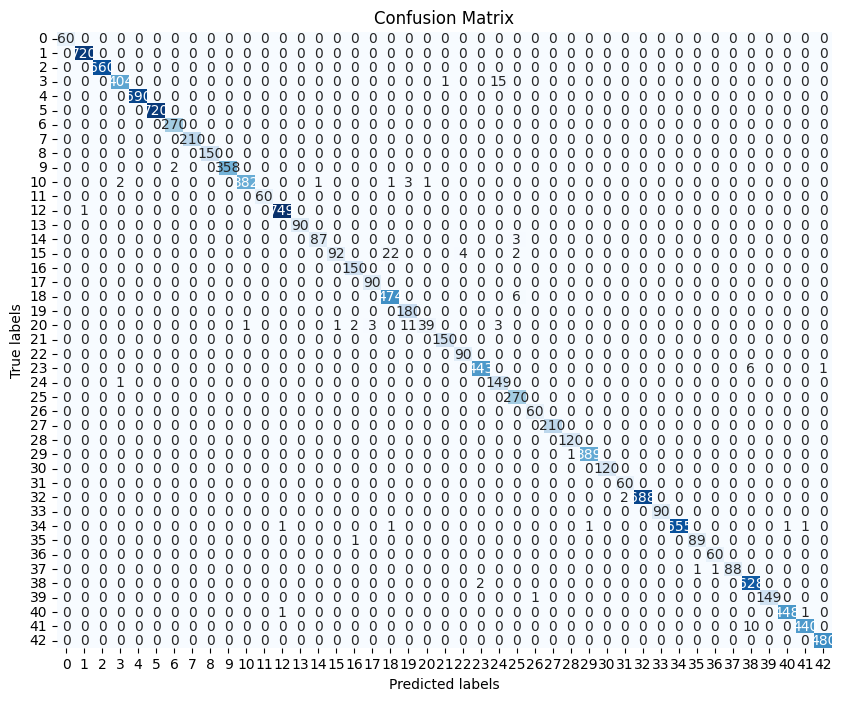

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       720
          10       1.00      1.00      1.00       660
          11       0.99      0.96      0.98       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00      0.99      1.00       360
          18       1.00      0.98      0.99       390
          19       1.00      1.00      1.00        60
           2       1.00      1.00      1.00       750
          20       1.00      1.00      1.00        90
          21       0.99      0.97      0.98        90
          22       0.99      0.77      0.86       120
          23       0.98      1.00      0.99       150
    

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Calculate classification report
    report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
    print("Classification Report:")
    print(report)
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print("Overall Accuracy:", accuracy)
    
    return cm, report, accuracy

# Evaluate the model
cm, report, accuracy = evaluate_model(model, test_loader)

In [7]:
# Define the file path for saving the model
save_path = 'efficientnetb7_traffic_signs.pth'

# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
    'num_epochs': NUM_EPOCHS,
    'class_labels': train_dataset.classes
}
torch.save(checkpoint, save_path)

print("Model saved successfully at:", save_path)

Model saved successfully at: efficientnetb7_traffic_signs.pth


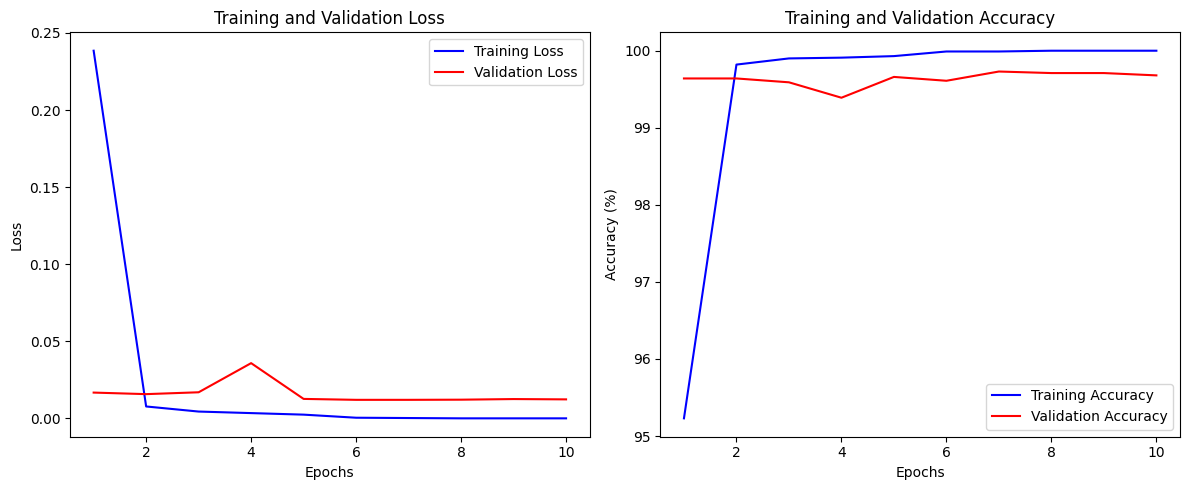

In [1]:
import matplotlib.pyplot as plt

epochs = range(1, 11)

training_loss = [0.2385, 0.0078, 0.0045, 0.0035, 0.0025, 0.0005, 0.0003, 0.0001, 0.0001, 0.0001]
training_accuracy = [95.23, 99.82, 99.90, 99.91, 99.93, 99.99, 99.99, 100.00, 100.00, 100.00]

validation_loss = [0.0168, 0.0158, 0.0170, 0.0359, 0.0127, 0.0121, 0.0121, 0.0122, 0.0126, 0.0124]
validation_accuracy = [99.64, 99.64, 99.59, 99.39, 99.66, 99.61, 99.73, 99.71, 99.71, 99.68]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()